# Final Project - Kalman Filter for Object Tracking in Images

---

90498 - Digital Image and Signal Processing

Laurea Magistrale - Computer science

Artificial Intelligence Track

University of Genova

---

Professors:

- Francesca Odone

- Alessandro Verri

---

Student:

- Arnaud Ruymaekers - S5298338

## Intro

- Imports

- Useful functions

- Fetching of the sequences of pictures

- Visualizing a sample

### Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy import signal
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature, io
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks

plt.rcParams['figure.figsize'] = [20,20] # Default plot size

### Useful functions

In [2]:
def allDistances(X1, X2):
    '''
    Function to rapidly compute the distances between all points of two series of points
    '''
    dist_d1 = np.tile(np.transpose(np.array([X1[:,0]])), (1, X2.shape[0])) - np.tile(X2[:,0], (X1.shape[0], 1))
    dist_d2 = np.tile(np.transpose(np.array([X1[:,1]])), (1, X2.shape[0])) - np.tile(X2[:,1], (X1.shape[0], 1))

    D = (dist_d1**2 + dist_d2**2)**(1/2)
    return D

In [3]:
def naive_KF(m, P_pred, s_pred, Phi, H, Q, R):
    """
    Naive Kalman Filter implementation.
    
    Inputs:
    - m (M-dim float) the new measurement
    - P_pred (NxN-dim float array) error covariance prediction
    - s_pred (N-dim float array) state prediction
    - Phi (float array) state transition matrix
    - H (MxN-dim float array) measurement matrix  
    - Q (NxN-dim float array) process noise covariance
    - R (MxM-dim float) measurement noise variance
    
    Outputs:
    - s
    - P_pred
    - s_pred
    """
    m_length = len(m)
    m = m.reshape(m_length, 1)

    # Kalman gain
    K = (P_pred @ H.transpose()) @ np.linalg.inv((H @ P_pred @ H.transpose()) + R)
    
    # Update step
    s = s_pred + (K @ (m - (H @ s_pred)))
    P_pred = (np.identity(len(s_pred)) - (K @ H)) @ P_pred
    
    # Projection step
    s_pred = Phi @ s
    P_pred = (Phi @ P_pred @ Phi.transpose()) + Q
    
    return s, P_pred, s_pred

### Loading of the image sequences

In [4]:
# Video 1
base_path = 'Source/'
pic_names = os.listdir(f'./{base_path}')
sequence = [io.imread(f'{base_path}/{name}') for name in pic_names]

In [5]:
# Video 2
base_path2 = 'Source2/'
pic_names2 = os.listdir(f'./{base_path2}')
sequence2 = [io.imread(f'{base_path2}/{name}') for name in pic_names2]

### Visualization of sample of each sequence

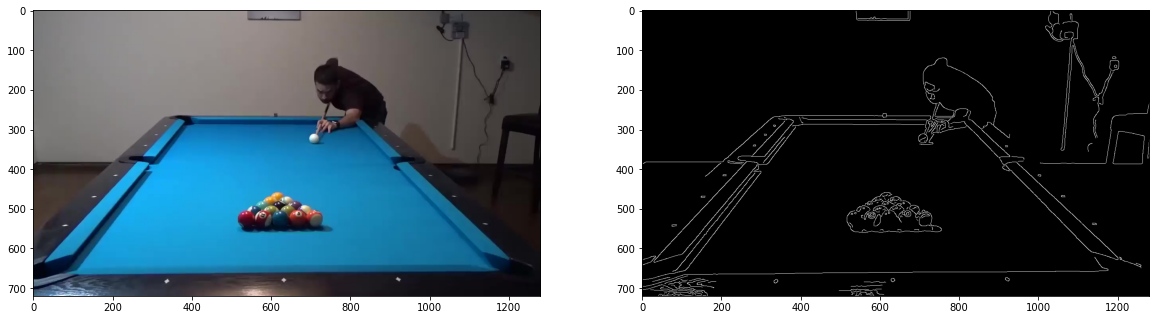

In [6]:
# Video 1 - frame 1
im0 = sequence[0]
im0_bw = color.rgb2gray(im0)
im0_edges = feature.canny(im0_bw, np.sqrt(2), 0.1) # Random params, better guesses will be done later

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im0)
ax2.imshow(im0_edges, cmap='gray')
plt.show()

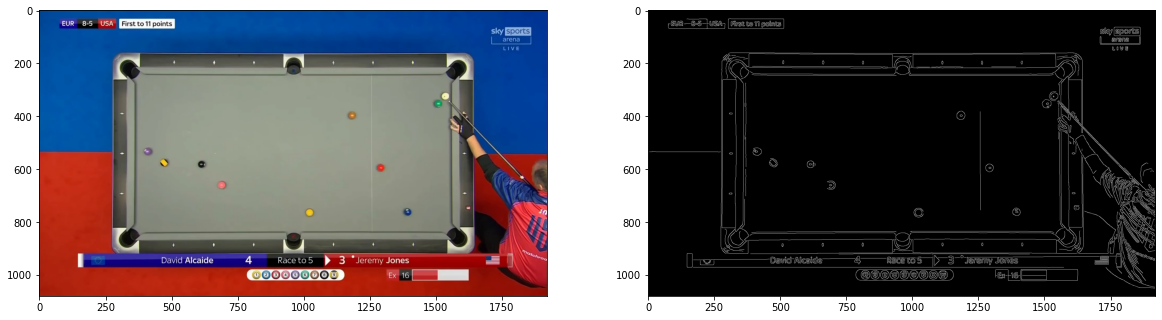

In [7]:
# Video 2 - frame 1
im0 = sequence2[0]
im0_bw = color.rgb2gray(color.rgba2rgb(im0))
im0_edges = feature.canny(im0_bw, np.sqrt(2), 0.1) # Random params, better guesses will be done later

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im0)
ax2.imshow(im0_edges, cmap='gray')
plt.show()

## First video - Image Processing

Finding the area of interest in the frames:

- Identifying the lines that make the boundaries of the playing area

- Finding the corners of the playing area in order to project like a birds-eye view

- Cropping the image to remove the unnecessary background

In [8]:
im0 = sequence[0]
im0_bw = color.rgb2gray(im0)
im0_edges = feature.canny(im0_bw, np.sqrt(2), 0.1) # Random params, better guesses will be done later

### Finding the lines in the image

y = -0.01 x + 666.75
y = 0.93 x + -497.19
y = -1.30 x + 799.44
y = -1.07 x + 663.72
y = 1.02 x + -543.05
y = 0.01 x + 262.56
y = 0.00 x + 274.57
y = 0.00 x + 286.58


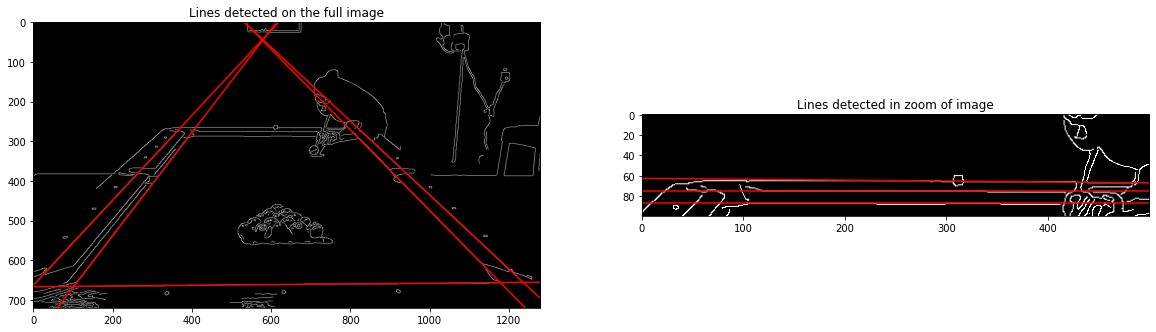

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
line_params = []

# Using Hough spaces to detect the lines in image
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(im0_edges, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Displaying image edges
ax1.set_title('Lines detected on the full image')
ax1.imshow(im0_edges, cmap='gray')
ax1.set_ylim(im0_edges.shape[0], 0)

# Storing the line parameters and plotting them
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    a = np.tan(angle + np.pi/2)
    b = (- a * x0) + y0
    line_params.append((a, b))
    ax1.axline((x0, y0), slope=np.tan(angle + np.pi/2), c='red')

'''
Finding top horizontal line
'''
# Using Hough space to find lines on zommed version of the image
zoomed_in_im0_edges = im0_edges[200:300, 300:800] # Values found by eyeballing
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(zoomed_in_im0_edges, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Displaying image edges (zoomed)
ax2.set_title('Lines detected in zoom of image')
ax2.imshow(zoomed_in_im0_edges, cmap='gray')
ax2.set_xlim(0)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    a = np.tan(angle + np.pi/2)
    b = (- a * x0) + y0 + 200  # to adjust for being zoomed in
    line_params.append((a, b))
    ax2.axline((x0, y0), slope=np.tan(angle + np.pi/2), c='red')
    
for line_param in line_params:
    print(f'y = {line_param[0]:.2f} x + {line_param[1]:.2f}')

### Finding the corners of the playing field

By analysing the coefficients we determine the following lines:

- y = -0.01 x + 666.75

- y = -1.30 x + 799.44

- y = 1.02 x + -543.05

- y = 0.00 x + 286.58

To be the boundaries of the table, now to we find the intersections of these lines in order to have points to make the projection of the image to a rectangle.

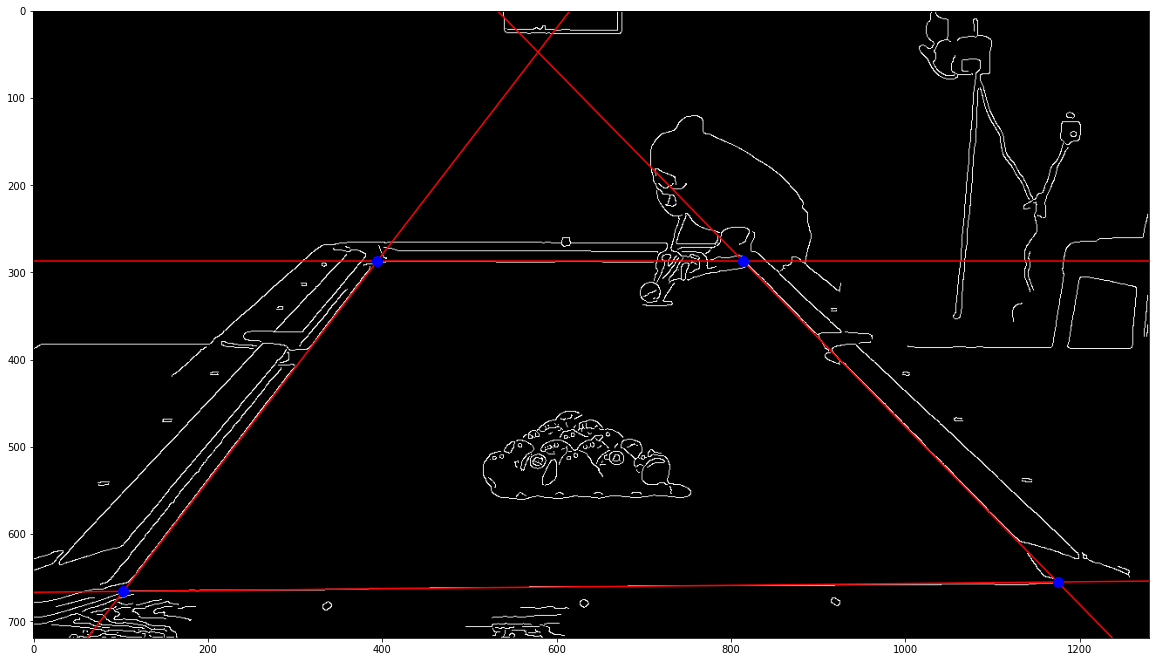

In [10]:
boundary_lines = np.array([(-0.01,666.75),
                           (-1.30,799.44),
                           (1.02,-543.05),
                           (0.00,286.58)])

# Index of the two lines forming each corner
corners_lines = np.array([(0,2), (0,1), (1,3), (2,3)])

# Compution of the corners
corners = np.zeros((4,2))
for i, corner_lines in enumerate(corners_lines):
    l1 = boundary_lines[corner_lines[0]]
    l2 = boundary_lines[corner_lines[1]]
    corners[i] = ((l2[1] - l1[1]) / (l1[0] - l2[0]), (l1[0] * ((l2[1] - l1[1]) / (l1[0] - l2[0]))) + l1[1])

# Plotting the corners found along with the tables boundary lines
plt.imshow(im0_edges, cmap='gray')
plt.ylim(im0_edges.shape[0]-1,0)
for line in boundary_lines:
    plt.axline((0, line[1]), slope=line[0], c='red',zorder=1)

plt.scatter(corners[:,0], corners[:,1], s=100, c='blue',zorder=2)
plt.show()

### Generating an image sequence of cropped images to have only the table in image and adjusting corner coordinates

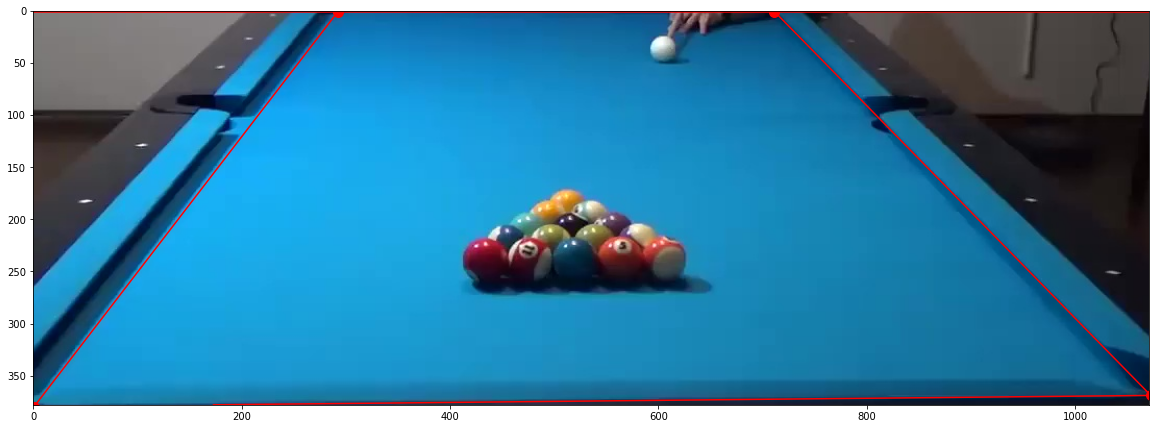

In [11]:
min_x = int(np.floor(np.min(corners[:,0])))
min_y = int(np.floor(np.min(corners[:,1])))
max_x = int(np.ceil(np.max(corners[:,0])))
max_y = int(np.ceil(np.max(corners[:,1])))

sequence_cropped = [im[min_y+1:max_y,min_x+1:max_x] for im in sequence]

# Extracting the cropped version of first image
im0_cropped = sequence_cropped[0]
im0_bw_cropped = color.rgb2gray(im0_cropped)
im0_edges_cropped = feature.canny(im0_bw_cropped, np.sqrt(2), 0.1)

# Finding the coordinates of corners on the cropped image sequence
corners_cropped = corners - (min_x,min_y)

# Finding the new boundary lines
corner_line = [(0,1),(0,3),(1,2),(2,3)]
boundary_lines_cropped = np.zeros((4,2))
for i, corners in enumerate(corner_line):
    c1 = corners_cropped[corners[0],:]
    c2 = corners_cropped[corners[1],:]
    m = (c2[1] - c1[1]) / (c2[0] - c1[0])
    b = c1[1] - (m * c1[0])
    boundary_lines_cropped[i] = (m, b)

# Plotting the cropped image along with the corners
plt.imshow(im0_cropped)
plt.ylim(im0_cropped.shape[0]-1,0)
plt.xlim(0,im0_cropped.shape[1]-1)
for line in boundary_lines_cropped:
    plt.axline((0, line[1]), slope=line[0], c='red',zorder=1)
plt.scatter(corners_cropped[:,0], corners_cropped[:,1], s=100, c='red')
plt.show()

### Finding the matrix to undo to perspective in order to have the pool table in a birds eye view

[[1.07256311e+03 3.69004369e+02]
 [8.60465116e-01 3.79721395e+02]
 [2.92507692e+02 5.80000000e-01]
 [7.11362745e+02 5.80000000e-01]]
To:
[[1072. 2144.]
 [   0. 2144.]
 [   0.    0.]
 [1072.    0.]]


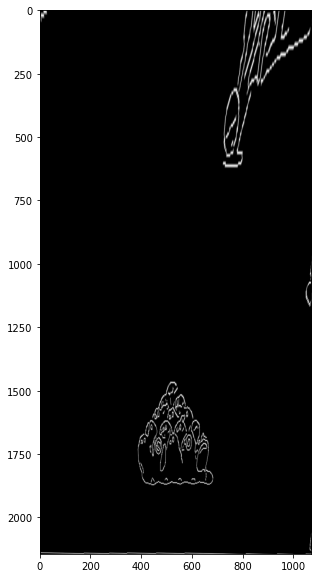

In [12]:
print(corners_cropped)

corners_cropped = np.float32(corners_cropped)
target_corners = np.float32([(1,1),(0,1),(0,0),(1,0)])
image_size = (im0_cropped.shape[1],im0_cropped.shape[1]*2) # Table with 1:2 ratio
target_corners *= image_size

print('To:')
print(target_corners)

matrix = cv2.getPerspectiveTransform(corners_cropped, target_corners)
im0_cropped_adj = cv2.warpPerspective(np.float32(im0_edges_cropped), matrix, image_size)

plt.figure(figsize = (5,10))
plt.imshow(im0_cropped_adj, cmap='gray')
plt.show()

### Generating a black mask for to reduce distracting elements to find the balls.

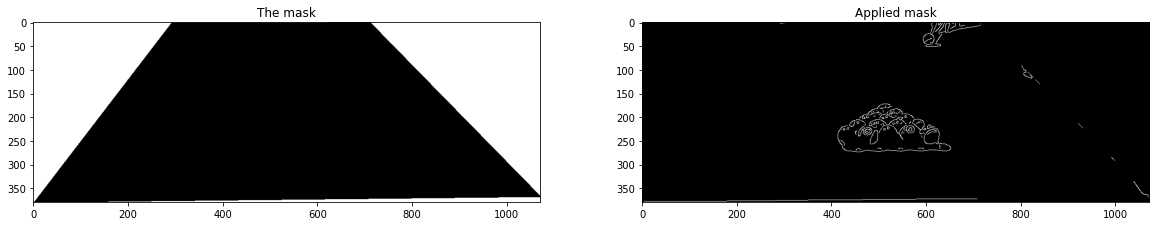

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# Generation of the mask
im_size = im0_edges_cropped.shape
A = np.arange(im_size[0] * im_size[1]).reshape(im_size)

line_masks = [(1,0), (0,1), (0,1), (0,1)] # To determine wether to check for point left/right of the curve
mask = np.zeros(im_size, dtype=int)
for i, line in enumerate(boundary_lines_cropped):
    mask |= np.where((A/im_size[1]) <= (((A%im_size[1]) * line[0]) + line[1]), line_masks[i][1], line_masks[i][0])
    
# Plotting of the mask and the mask applied
im0_edges_cropped_masked = np.where(mask==1, 0, im0_edges_cropped)
ax1.imshow(mask*255, cmap='gray')
ax1.set_title('The mask')
ax2.imshow(im0_edges_cropped_masked, cmap='gray')
ax2.set_title('Applied mask')
plt.show()

## First Video - Object tracking

Now that the image sequence is processed to minimize distracting elements and the perspective inversion matrix is generated, we can start on attempting to track the various balls.

### Running hough circle

To find the ball positions, we use the orginal image (before inverse perspective transformation). On this image we run the Hough circles algorithm where we constraint the centers to be at least 20 pixels appart in the x and y direction and we check circle radii from 11 to 19 pixels. We also constraint the algorithm to find the 16 best circles founds.

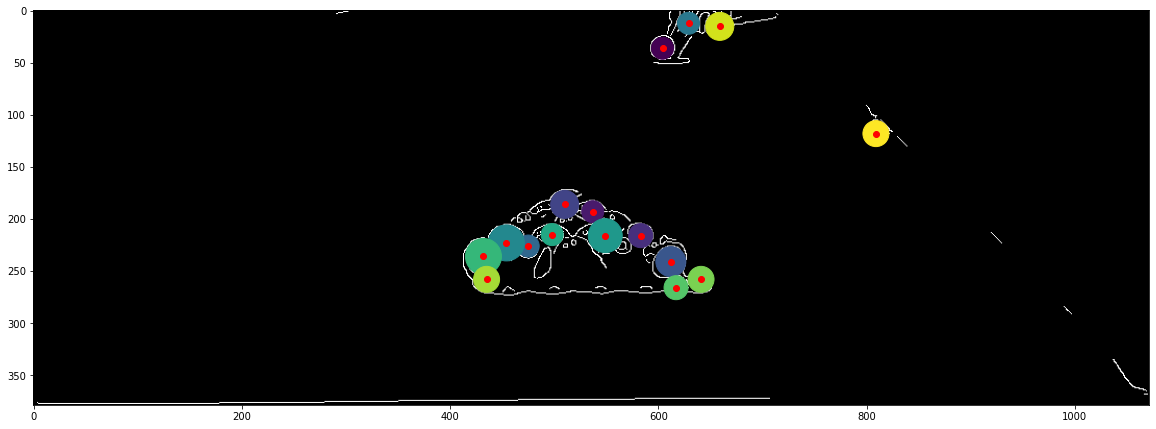

[[604  36  11]
 [537 193  11]
 [583 216  12]
 [510 186  14]
 [612 241  15]
 [475 226  11]
 [629  12  11]
 [454 223  18]
 [549 216  17]
 [498 215  11]
 [432 236  18]
 [617 266  12]
 [641 258  13]
 [435 258  13]
 [659  15  14]
 [809 118  13]]


In [14]:
try_radii = np.arange(11, 19)
hspaces = hough_circle(im0_edges_cropped_masked, try_radii)
acum, cx, cy, rad = hough_circle_peaks(hspaces, 
                                       try_radii, 
                                       min_xdistance=20, 
                                       min_ydistance=20, 
                                       total_num_peaks=16)

circles = np.vstack((cx,cy,rad)).T

plt.scatter(circles[:,0], circles[:,1], s=(circles[:,2]*2)**2, c=np.arange(len(circles[:,0]))*10)
plt.scatter(circles[:,0], circles[:,1], c='red')
plt.imshow(im0_edges_cropped_masked, cmap='gray')
plt.show()

print(circles)

### Picking the white ball

In order to perform the object tracking, let's focus on one object, the white ball. By analysis, we find that the white ball object is the first in the list.

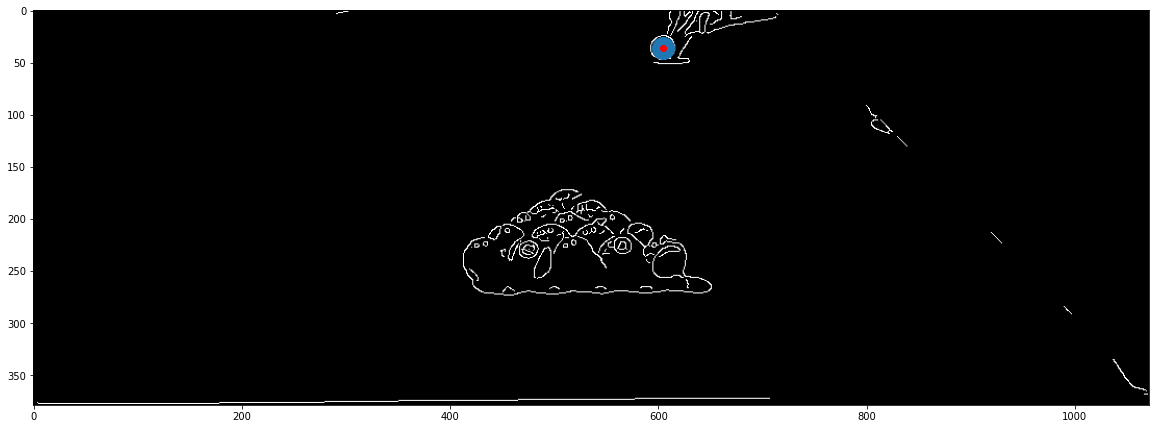

In [15]:
ball0 = circles[0]

plt.scatter(ball0[0], ball0[1], s=(ball0[2]*2)**2)
plt.scatter(ball0[0], ball0[1], c='red')
plt.imshow(im0_edges_cropped_masked, cmap='gray')
plt.show()

### Generating the position list for the whole sequence

Even if the algorithm didn't find all the circles and instead found them on the hand of the player, let's find the positions of the circles on the whole sequence of images.

In [16]:
sequence_positions = []
for i, im in enumerate(sequence_cropped):
    # Processing the image
    im_bw = color.rgb2gray(im)
    im_edges = feature.canny(im_bw, np.sqrt(2), 0.1)
    im_edges_masked = np.where(mask==1, 0, im_edges)
    
    # Finding the balls
    try_radii = np.arange(10, 20)
    hspaces = hough_circle(im_edges_masked, try_radii)
    acum, cx, cy, rad = hough_circle_peaks(hspaces,
                                           try_radii,
                                           min_xdistance=10,
                                           min_ydistance=10)

    circles = np.vstack((cx,cy)).T
    
    sequence_positions.append(circles)

### Attempting to find the sequence of positions of the white ball

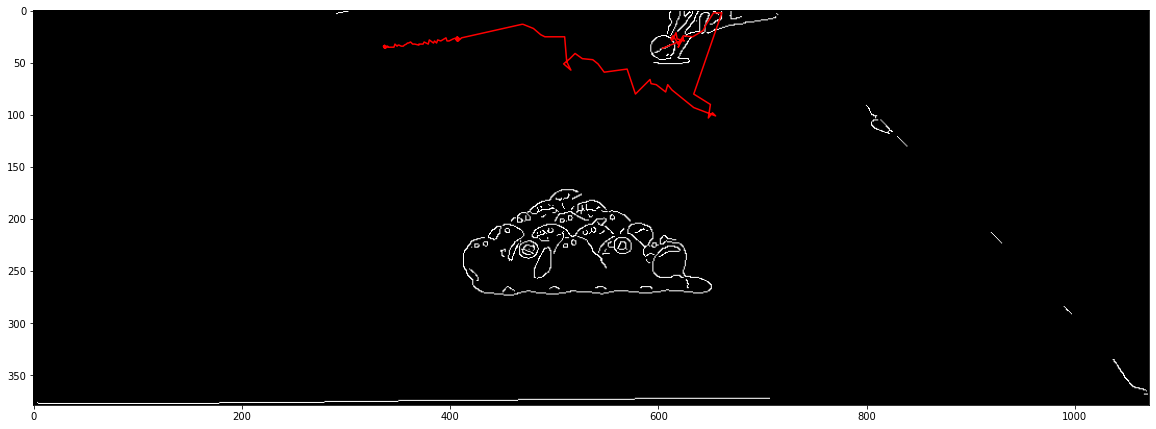

In [17]:
ball0_positions = [ball0[:2]]

for i, positions in enumerate(sequence_positions[1:]):
    dists = allDistances(ball0_positions[-1].reshape(1,2), positions)
    ball0_positions.append(positions[np.argmin(dists)])
    
ball0_positions = np.array(ball0_positions)

plt.plot(ball0_positions[:,0], ball0_positions[:,1], c='red')
plt.imshow(im0_edges_cropped_masked, cmap='gray')
plt.show()

### Observation:

On this dataset, due to lighting artifact and the hough circles finding circles around the hand of the player. It was impossible to generate a satisfactory position sequence to feed to the kalman filter. Within the scope of this project, it was not worth to develop something more complicated to find the balls (something like AI image recognition for example).

Hence my decision to find another image sequence with minimal distraction, the sequence of images is taken from the top down, the player's hand doesn't come on the table, and the lighting artifacts appear in the center of the balls, minimizing possible distracting circles. Another point with this new image sequence is that, since there is no perspective, the ball all have approximatively the same radius, so the Hough-circles algorithm will be easy to give good parameters to to only find the balls. Another problem of the perspective in the previous image sequence is that balls could be masked by another ball making it confusing once again for the Hough-circles algorithm.

## Video 2 - Image Processing

In [18]:
im0 = sequence2[0]
im0_bw = color.rgb2gray(color.rgba2rgb(im0))
im0_edges = feature.canny(im0_bw, np.sqrt(2), 0.1) # Random params, better guesses will be done later

### Finding Playing Field edges

This is much easier as the table is almost a perfect rectangle, so just taking a slice in the X and one in Y direction should be able to tell us were the edges fall.

In [19]:
# Y direction playing field edges
print('Slice in the Y direction')
print(np.argwhere(im0_edges[:,550]).T)

# Y direction playing field edges
print('\nSlice in the X direction')
print(np.argwhere(im0_edges[800,:]).T)

Slice in the Y direction
[[162 165 213 218 241 246 837 843 867 920 939 971]]

Slice in the X direction
[[   1  276  279  331  358  364 1558 1563 1590 1641 1645 1729 1730 1772
  1777 1779 1784 1789 1796 1800 1801 1806 1812 1824 1831 1832 1839 1851
  1854 1855 1860 1861 1874 1875 1881 1882 1895 1907]]


By analysis, we find that:
- In the Y direction, the edges are at the coordinates, Y=837 and Y=246
- In the X direction, the edges are at the coordinates, X=364 and X=1558

Let's verify by plotting the image and limit the x and y ranges

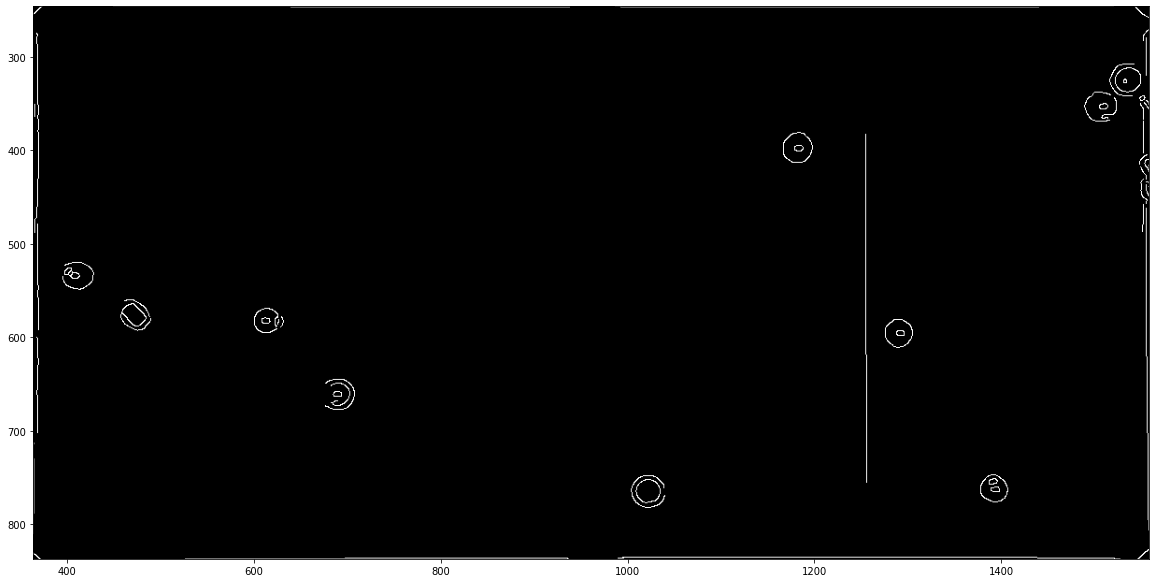

In [20]:
plt.imshow(im0_edges, cmap='gray')
plt.ylim(837,246)
plt.xlim(364,1558)
plt.show()

Adjusting a few pixels to remove the unnecessary lines on the sides of the field, we get:
- Y in [247,834]
- X in [370, 1550]

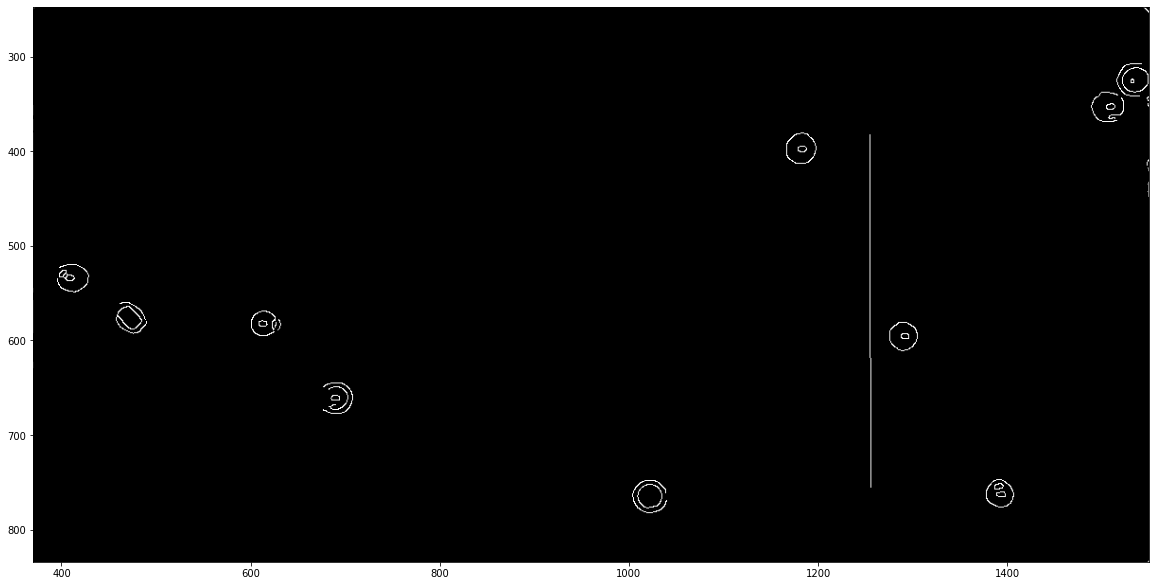

In [21]:
plt.imshow(im0_edges, cmap='gray')
plt.ylim(834,247)
plt.xlim(370,1550)
plt.show()

### Tuning of Canny algorithms

Better parameters for Canny algorithm, 1.5 sigma with a treshold of 0.1 seems to work and has the added benefit of making the line on the field disappear.

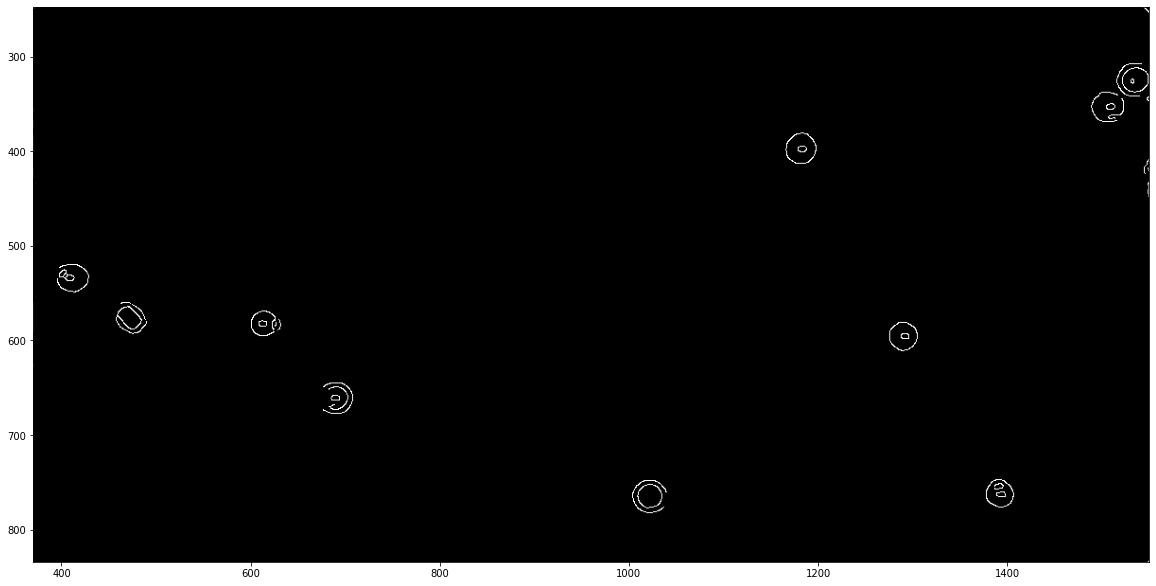

In [22]:
im0_edges_test = feature.canny(im0_bw, 1.5, 0.1)

plt.imshow(im0_edges_test, cmap='gray')
plt.ylim(834,247)
plt.xlim(370,1550)
plt.show()

### Processed image sequence

Let's now generate a sequence_processed. It will crop the picture and apply Canny edge detection directly.

No movement happening before image 69, so let's process the images after this one

In [23]:
sequence2_process = []
for im in sequence2[68:]:
    im_bw = color.rgb2gray(color.rgba2rgb(im))
    im_edges = feature.canny(im_bw, 1.5, 0.1)
    sequence2_process.append(im_edges[247:834,370:1550])

## Video 2 - Object Tracking

Let's now attempt to find the ball using hough circles. In this new image sequence, we can reduce the radii set to only check from 12 to 17 pixels of radius. Also in this game, more ball have been sinked so we only need to check for 10 balls.

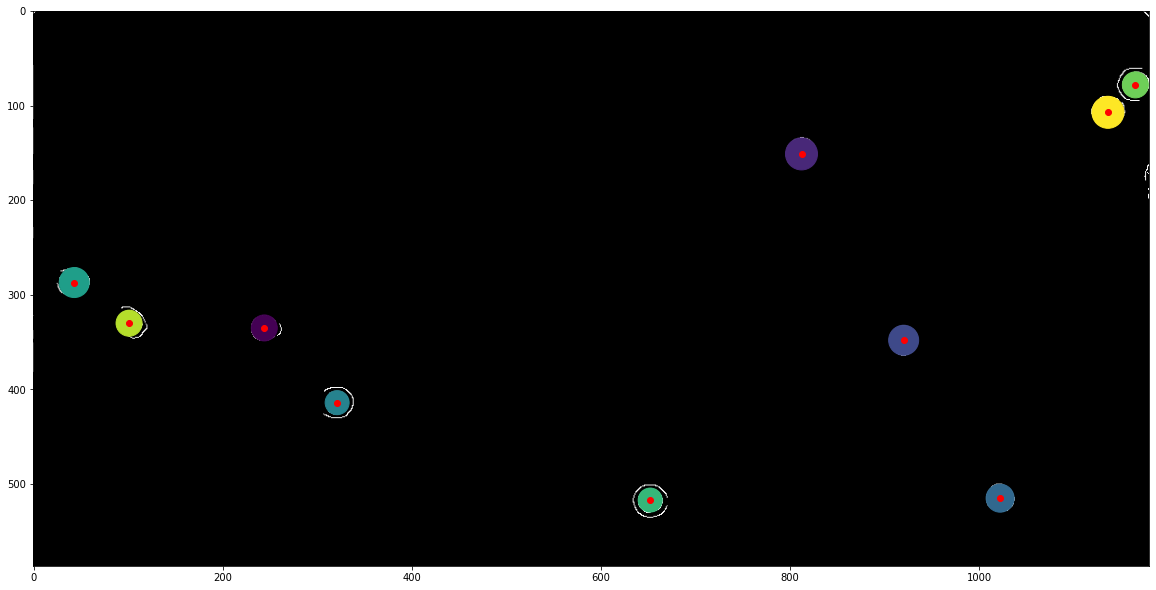

In [24]:
im0 = sequence2_process[0]

try_radii = np.arange(12, 17)
hspaces = hough_circle(im0, try_radii)
acum, cx, cy, rad = hough_circle_peaks(hspaces, 
                                       try_radii, 
                                       min_xdistance=20, 
                                       min_ydistance=20, 
                                       total_num_peaks=10)

circles = np.vstack((cx,cy,rad)).T

plt.scatter(circles[:,0], circles[:,1], s=(circles[:,2]*2)**2, c=np.arange(len(circles[:,0]))*10)
plt.scatter(circles[:,0], circles[:,1], c='red')
plt.imshow(im0, cmap='gray')
plt.show()

### Finding the positions on the whole sequence

We found an accurate positioning of the balls in the images, now let's run the Hough algorithm on the whole sequence of images.

In [25]:
sequence2_positions = []
for im in sequence2_process:
    try_radii = np.arange(12, 17)
    hspaces = hough_circle(im, try_radii)
    acum, cx, cy, rad = hough_circle_peaks(hspaces, 
                                           try_radii, 
                                           min_xdistance=20, 
                                           min_ydistance=20, 
                                           total_num_peaks=10)

    circles = np.vstack((cx,cy)).T
    sequence2_positions.append(circles)
    
print(sequence2_positions[0])

[[ 244  335]
 [ 812  151]
 [ 920  348]
 [1022  515]
 [ 321  414]
 [  43  287]
 [ 652  517]
 [1165   78]
 [ 101  330]
 [1136  107]]


Verification of the positions:

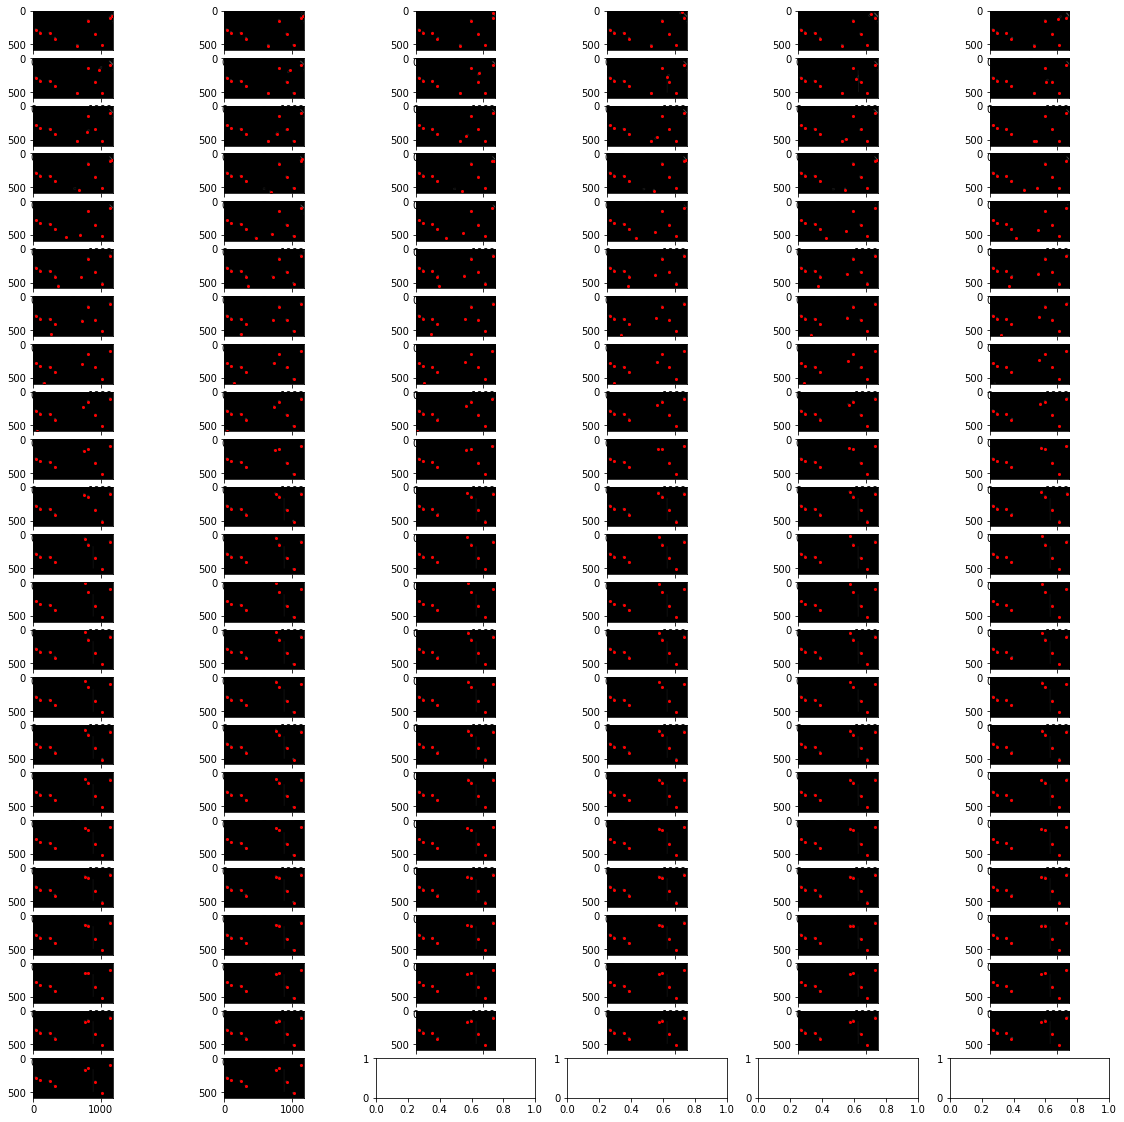

In [26]:
fig,axes = plt.subplots(23, 6)
for i, im in enumerate(sequence2_process):
    ax = axes[int(i/6),i%6]
    ax.imshow(im,cmap='gray')
    ax.scatter(sequence2_positions[i][:,0], sequence2_positions[i][:,1], s=4, c='red')
plt.show()

### Removing distracting static positions

Now we can apply tracking on both the white ball and/or the yellow ball. Let's remove the positions found for the balls that don't move.
By analysing the center coordinates, we know that the white ball is at positions (1165,78) and the yellow at position (652, 517).

The remainder of the balls should not be moving so let's remove them:

In [27]:
still_balls = [
    np.array((244, 335)),
    np.array((812, 151)),
    np.array((920, 348)),
    np.array((1022, 515)),
    np.array((321, 414)),
    np.array((43, 287)),
    np.array((101, 330)),
    np.array((1136, 107))
]

for ball in still_balls:
    for i, positions in enumerate(sequence2_positions):
        dists = allDistances(ball.reshape(1,2), positions)
        sequence2_positions[i] = np.delete(sequence2_positions[i], np.argmin(dists), axis=0)

### White ball position sequence

From this currated sequence of position lists, we will find the positions of the white ball as for the yellow ball, we would need to build some more accurate object tracking. This is due to the fast movement, in the 6 first frames after the hit, the algorithm doesnt catch the moving yellow ball.

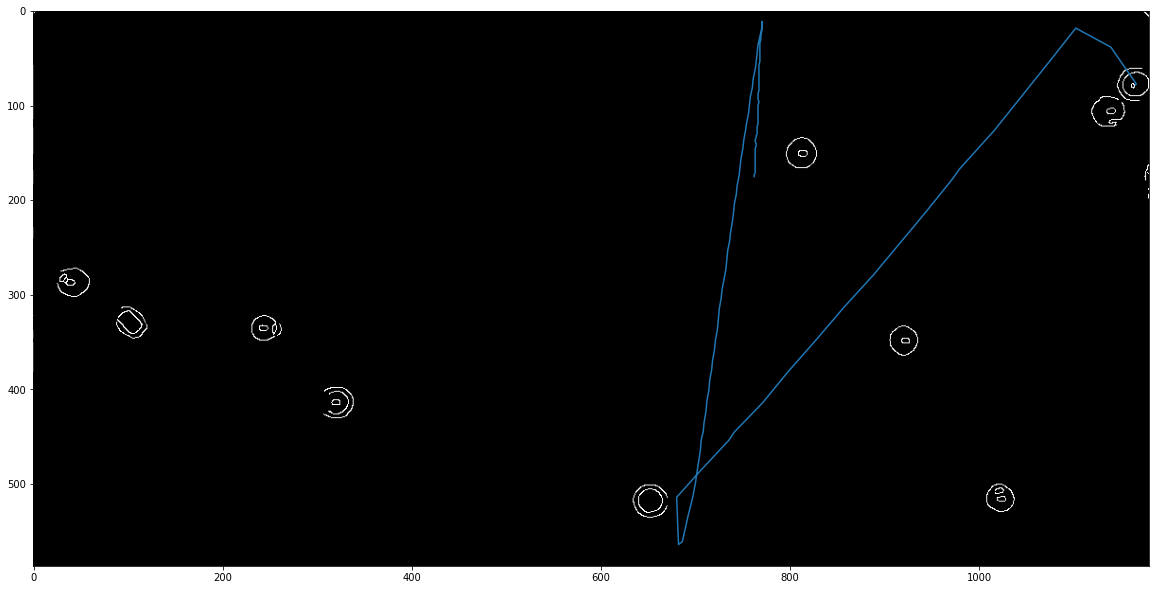

In [28]:
white_ball_positions = [np.array((1165,78))]
for positions in sequence2_positions:
    dists = allDistances(white_ball_positions[-1].reshape(1,2), positions)
    white_ball_positions.append(positions[np.argmin(dists)])

white_ball_positions = np.array(white_ball_positions)
plt.imshow(sequence2_process[0], cmap='gray')
plt.plot(white_ball_positions[:,0], white_ball_positions[:,1])
plt.show()

## Video 2 - Kalmann filtering of the white ball's movement

Now that we have a good tracking of the ball we can go ahead and apply a Kalman filter on these recorded positions to attempt to correct the innacuracies. For the filtering of the position, compared to what we saw in the lab and the the midterm where the filter was in 1D, here we are filtering a movement in 2D.

We will also convert the pixel coordinate to real life measurements. We know the table of this video sequence is a 9foot table so the playing field is (127cm ,254cm).

The state will be [x, y, x', y', x'', y'']

Fixed Variables:

In [29]:
fps = 25
delta_t = 1/fps

n=4
Phi = np.array([
    [1, 0, delta_t, 0],
    [0, 1, 0, delta_t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
Q = np.array([
    [0.01, 0, 0, 0],
    [0, 0.01, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])
R = 0.01

### Seting of remainder of variables and running of Kalmann filtering on the sequence of positions

In [30]:
s_pred = np.ones((n,1))
s_pred[0] = white_ball_positions[0][0]
s_pred[1] = white_ball_positions[0][1]

# Initial guess of the standard deviation
P_pred = np.zeros((n,n))
P_pred[0,0] = 25
P_pred[1,1] = 25

filtered_states = [s_pred]

# Filtering loop
for i, m in enumerate(white_ball_positions):
    s, P_pred_new, s_pred_new = naive_KF(np.array(m), P_pred, s_pred, Phi, H, Q, R)
    P_pred = P_pred_new.copy()
    s_pred = s_pred_new.copy()
    filtered_states.append(s_pred)
    
filtered_states = np.array(filtered_states)
filtered_states = filtered_states.reshape(filtered_states.shape[:2])

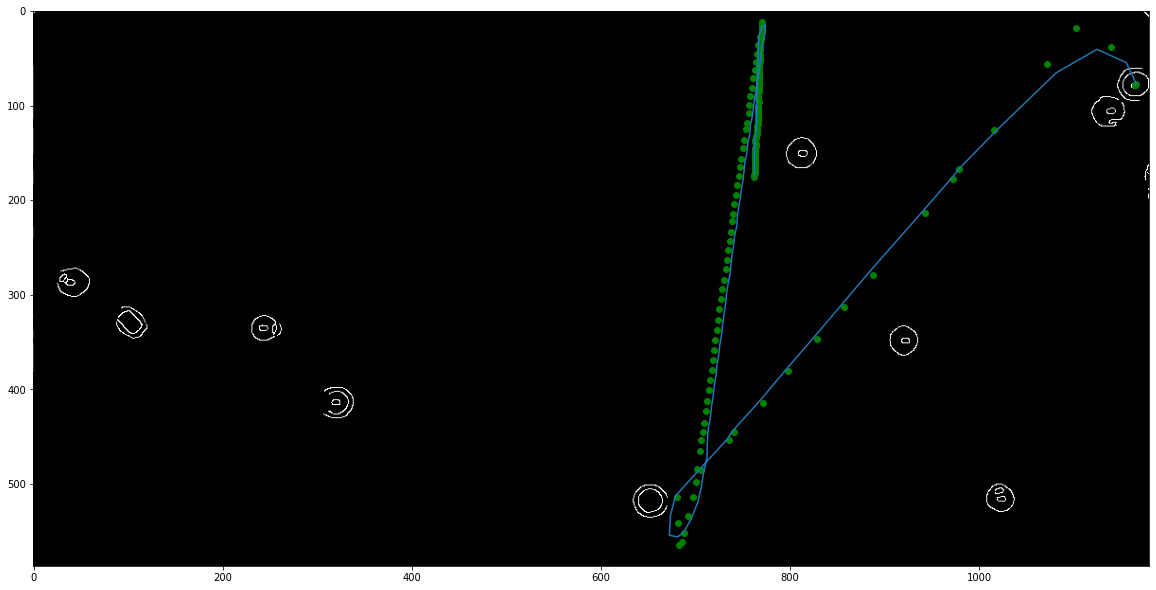

In [31]:
plt.imshow(sequence2_process[0], cmap='gray')
plt.scatter(white_ball_positions[:,0], white_ball_positions[:,1], c='green')
plt.plot(filtered_states[:,0],filtered_states[:,1])
plt.show()

### Observation and conclusions

For the Kalman filter function to work compared to the labs, it had to be corrected. Since the measurements were 2D data, the m=2, this resulted in the \*\*-1 operation of the kalman gain equation to have to be applied on a 2x2 matrix instead of a single number. This meant matrix inversion had to be applied instead of simple division.

We can observe after running the measurements through the Kalman filter, the observed improvement is minor. In addition, due to how the Kalman filtering works, the hits againsts the walls where a sharp turn is to be expected, it is smoothed out to appear as curve.

## References

- Video 1: https://www.youtube.com/watch?v=Pf-DVBopHSo&t=4s
- Video 2: https://www.youtube.com/watch?v=F50y2mTtsKA
- https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html
- https://www.geeksforgeeks.org/perspective-transformation-python-opencv/
- https://www.kalmanfilter.net/default.aspx